In [ ]:
# https://quera.org/problemset/211020   پروازهای روسیه

In [560]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import sqlalchemy as db

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [ ]:
user = 'postgres'
password = '*********'
host = '127.0.0.1'
port = 5432
database = 'russian_air'

In [ ]:
url="postgresql://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, database)

engine = db.create_engine(url,pool_pre_ping=True)
conn = engine.connect() 
metadata = db.MetaData() 

In [75]:
aircrafts_data = db.Table('aircrafts_data', metadata,autoload_with=engine ,extend_existing=True)
airports_data = db.Table('airports_data', metadata,metadata,autoload_with=engine ,extend_existing=True)
boarding_passes = db.Table('boarding_passes', metadata,metadata,autoload_with=engine ,extend_existing=True)
flights = db.Table('flights', metadata,metadata,autoload_with=engine ,extend_existing=True)
seats = db.Table('seats', metadata,metadata,autoload_with=engine ,extend_existing=True)
ticket_flights = db.Table('ticket_flights', metadata,metadata,autoload_with=engine ,extend_existing=True)
tickets = db.Table('tickets', metadata,metadata,autoload_with=engine ,extend_existing=True)
metadata.create_all(engine) 

In [76]:
for t in metadata.sorted_tables:
    print(t.name)

aircrafts_data
airports_data
boarding_passes
flights
seats
ticket_flights
tickets


1: Number of seats per plane by class

In [94]:
query = seats.select()
output = conn.execute(query).fetchall()
df1 = pd.DataFrame(output)

In [522]:
df1 = df1.groupby(["aircraft_code","fare_conditions"]).count().reset_index().sort_values(by=["aircraft_code","seat_no"],ascending=[True,False])\
    .rename(columns={"seat_no": "count" })
df1

,aircraft_code,fare_conditions,count
1,319,Economy,96
0,319,Business,20
3,320,Economy,120
2,320,Business,20
5,321,Economy,142
4,321,Business,28
7,733,Economy,118
6,733,Business,12
9,763,Economy,192
8,763,Business,30


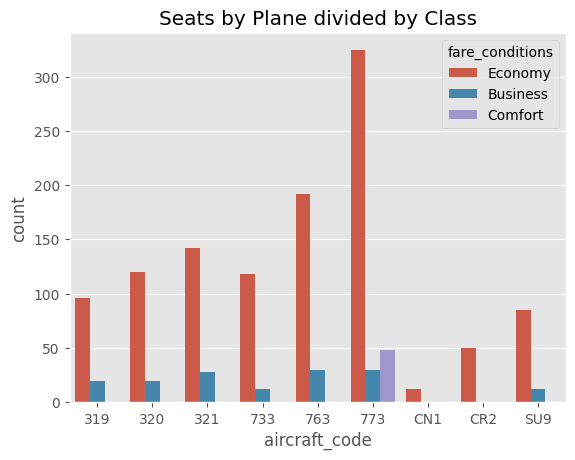

In [561]:
sns.barplot(data = df1 , x = "aircraft_code",y="count" ,hue="fare_conditions")\
    .set(title = "Seats by Plane divided by Class");

2 : Total number of canceled flights on different days of the week

In [102]:
query = flights.select().where(flights.columns.status == 'Cancelled')
output = conn.execute(query).fetchall()
df2 = pd.DataFrame(output)
df2.scheduled_departure = pd.to_datetime(df2.scheduled_departure).dt.day_name()

In [532]:
df2 = df2.groupby("scheduled_departure").count()["status"].to_frame().reset_index().sort_values(by=["status","scheduled_departure"],ascending=[False,True])\
    .rename(columns={"scheduled_departure": "day","status": "count"}).reset_index(drop=True)
df2

,day,count
0,Wednesday,2
1,Thursday,1
2,Tuesday,1


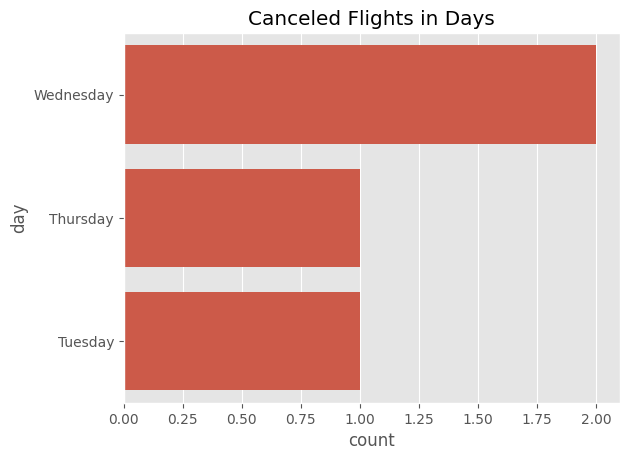

In [562]:
sns.barplot(data= df2, x="count", y="day" ).set(title= "Canceled Flights in Days");

3: Ranking of the number of passengers transported at airports by different aircraft

In [344]:
query1 = db.select(flights.columns.flight_id, 
                  flights.columns.departure_airport, 
                  flights.columns.aircraft_code).where(flights.columns.status != 'Cancelled')
output1 = conn.execute(query1).fetchall()

query2 = db.select(flights.columns.flight_id, 
                  flights.columns.arrival_airport, 
                  flights.columns.aircraft_code).where(flights.columns.status != 'Cancelled')
output2 = conn.execute(query2).fetchall()
df3 = pd.concat([pd.DataFrame(output1).rename(columns={"departure_airport": "airport_code"}),
                 pd.DataFrame(output2).rename(columns={"arrival_airport": "airport_code"})])
df3

,flight_id,airport_code,aircraft_code
0,1,DME,321
1,15,DME,321
2,19,DME,321
3,20,DME,321
4,21,DME,321
...,...,...,...
8682,33103,SVO,CR2
8683,33105,SVO,CR2
8684,33110,SVO,CR2
8685,33114,SVO,CR2


In [345]:
query3 = db.select(ticket_flights.columns.ticket_no,ticket_flights.columns.flight_id)
output3 = conn.execute(query3).fetchall()
df_t1 = pd.DataFrame(output3)

In [346]:
df3["count"] = df3["flight_id"].map(df_t1.flight_id.value_counts())
df3.dropna(inplace=True)
df3 = df3.drop("flight_id",axis=1)
df3.reset_index(drop=True,inplace=True)

In [347]:
df3 = df3.groupby(["airport_code","aircraft_code"]).sum("count").reset_index()
df3

,airport_code,aircraft_code,count
0,AAQ,733,2765.0
1,AAQ,SU9,2017.0
2,ABA,319,405.0
3,ABA,CN1,435.0
4,AER,319,249.0
...,...,...,...
213,VVO,763,772.0
214,VVO,CR2,177.0
215,VVO,SU9,1988.0
216,YKS,319,328.0


In [348]:
query4 = db.select(airports_data.columns.airport_code,airports_data.columns.airport_name)
output4 = conn.execute(query4).fetchall()
df_airport_name = pd.DataFrame(output4)

In [349]:
query5 = db.select(aircrafts_data.columns.aircraft_code,aircrafts_data.columns.model)
output5 = conn.execute(query5).fetchall()
df_aircraft_model = pd.DataFrame(output5)

In [350]:
df3["aircraft_model"] = df3["aircraft_code"].map(df_aircraft_model.set_index("aircraft_code").squeeze())
df3["airport"] = df3["airport_code"].map(df_airport_name.set_index("airport_code").squeeze().apply(lambda x: x['en']))
df3 = df3.drop(columns=["airport_code","aircraft_code"])
df3 = df3.sort_values(["airport","count"],ascending=[True,False]).reset_index(drop=True)
df3

,count,aircraft_model,airport
0,435.0,Cessna 208 Caravan,Abakan Airport
1,405.0,Airbus A319-100,Abakan Airport
2,2765.0,Boeing 737-300,Anapa Vityazevo Airport
3,2017.0,Sukhoi Superjet-100,Anapa Vityazevo Airport
4,1246.0,Bombardier CRJ-200,Astrakhan Airport
...,...,...,...
213,1106.0,Sukhoi Superjet-100,Yemelyanovo Airport
214,945.0,Bombardier CRJ-200,Yemelyanovo Airport
215,208.0,Cessna 208 Caravan,Yemelyanovo Airport
216,2406.0,Airbus A319-100,Yuzhno-Sakhalinsk Airport


In [351]:
df_t = df3.groupby("airport")["count"].apply(lambda x: x.rank(method = "dense",ascending = False)).to_frame().reset_index(drop=True)
df3["rank"] = df_t
df3

,count,aircraft_model,airport,rank
0,435.0,Cessna 208 Caravan,Abakan Airport,1.0
1,405.0,Airbus A319-100,Abakan Airport,2.0
2,2765.0,Boeing 737-300,Anapa Vityazevo Airport,1.0
3,2017.0,Sukhoi Superjet-100,Anapa Vityazevo Airport,2.0
4,1246.0,Bombardier CRJ-200,Astrakhan Airport,1.0
...,...,...,...,...
213,1106.0,Sukhoi Superjet-100,Yemelyanovo Airport,2.0
214,945.0,Bombardier CRJ-200,Yemelyanovo Airport,3.0
215,208.0,Cessna 208 Caravan,Yemelyanovo Airport,4.0
216,2406.0,Airbus A319-100,Yuzhno-Sakhalinsk Airport,1.0


In [352]:
df3 = df3.reindex(columns=["airport","aircraft_model","count","rank"])
df3

,airport,aircraft_model,count,rank
0,Abakan Airport,Cessna 208 Caravan,435.0,1.0
1,Abakan Airport,Airbus A319-100,405.0,2.0
2,Anapa Vityazevo Airport,Boeing 737-300,2765.0,1.0
3,Anapa Vityazevo Airport,Sukhoi Superjet-100,2017.0,2.0
4,Astrakhan Airport,Bombardier CRJ-200,1246.0,1.0
...,...,...,...,...
213,Yemelyanovo Airport,Sukhoi Superjet-100,1106.0,2.0
214,Yemelyanovo Airport,Bombardier CRJ-200,945.0,3.0
215,Yemelyanovo Airport,Cessna 208 Caravan,208.0,4.0
216,Yuzhno-Sakhalinsk Airport,Airbus A319-100,2406.0,1.0


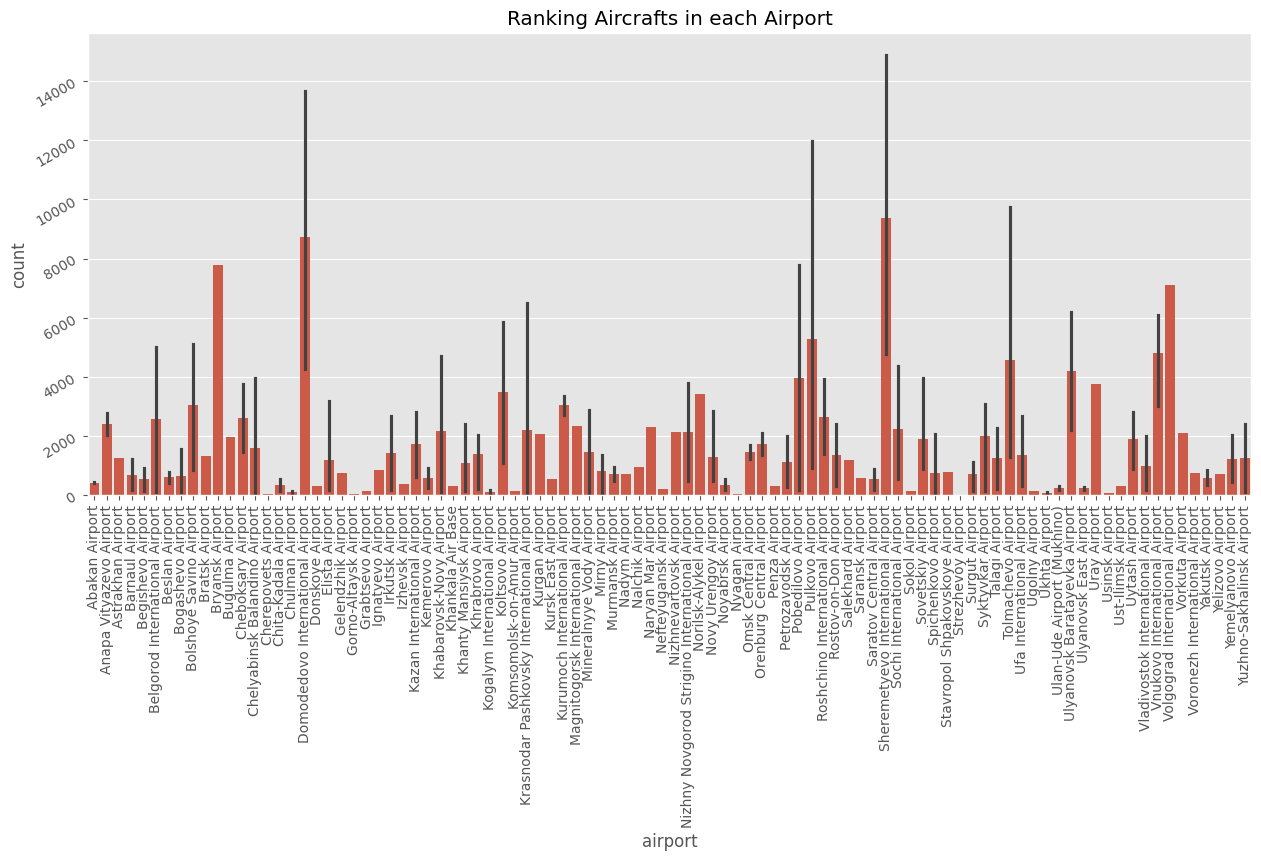

In [630]:
plt.figure(figsize=(15,6))
sns.barplot(data=df3, x= "airport",y="count")\
    .set(title = "Ranking Aircrafts in each Airport")
plt.xticks(rotation=90)
plt.yticks(rotation=30)
plt.legend = True;

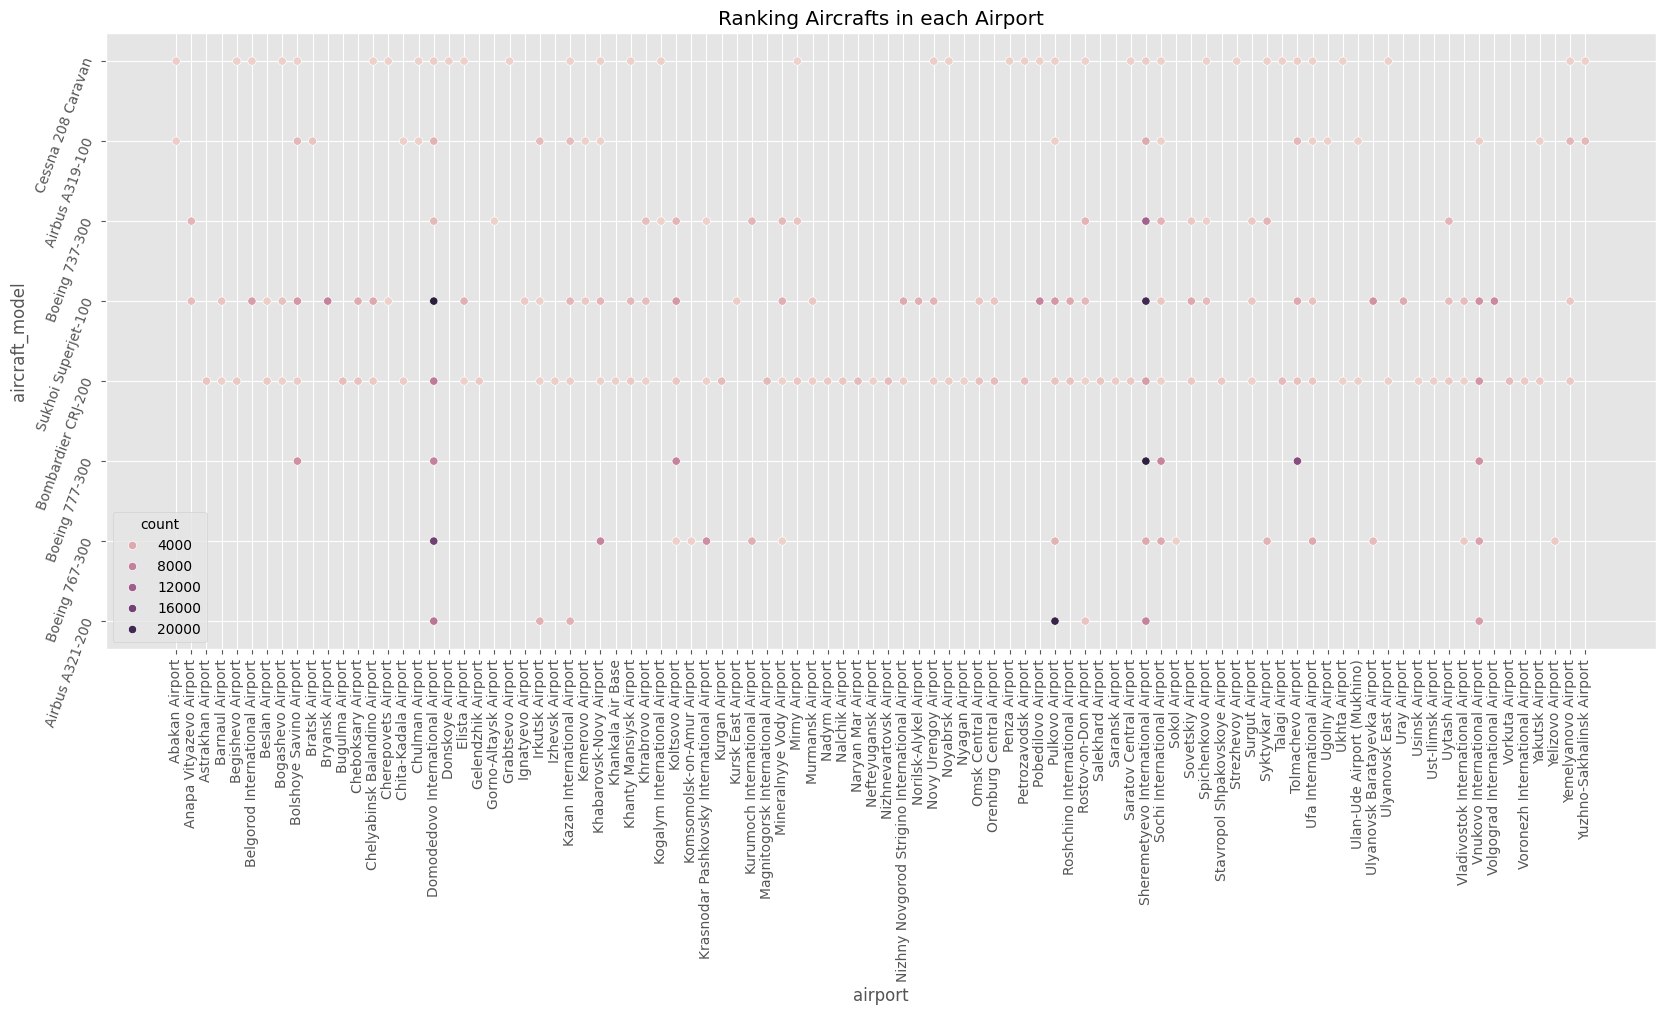

In [647]:
plt.figure(figsize=(20,8))
sns.scatterplot(data=df3, x= "airport",y="aircraft_model",hue="count")\
    .set(title = "Ranking Aircrafts in each Airport")
plt.xticks(rotation=90);
plt.yticks(rotation=70);

4: Time difference between different cities

In [503]:
query6 = db.select(flights.columns.scheduled_departure,
                   flights.columns.scheduled_arrival,
                   flights.columns.departure_airport,
                   flights.columns.arrival_airport)
output6 = conn.execute(query6).fetchall()
df4 = pd.DataFrame(output6)

In [504]:
df4.scheduled_departure = pd.to_datetime(df4.scheduled_departure)
df4.scheduled_arrival = pd.to_datetime(df4.scheduled_arrival)
df4["time_diffrrence"] = (df4.scheduled_arrival - df4.scheduled_departure).dt.total_seconds() /60
df4 = df4.drop(columns=["scheduled_arrival","scheduled_departure"])
df4

,departure_airport,arrival_airport,time_diffrrence
0,DME,LED,55.0
1,DME,LED,55.0
2,DME,LED,55.0
3,DME,LED,55.0
4,DME,LED,55.0
...,...,...,...
8686,SKX,SVO,45.0
8687,SKX,SVO,45.0
8688,SKX,SVO,45.0
8689,SKX,SVO,45.0


In [505]:
df4 = df4.groupby(["departure_airport","arrival_airport"]).mean("time_diffrrence").reset_index()
df4

,departure_airport,arrival_airport,time_diffrrence
0,AAQ,EGO,50.0
1,AAQ,NOZ,305.0
2,AAQ,SVO,100.0
3,ABA,ARH,240.0
4,ABA,DME,265.0
...,...,...,...
613,YKS,BAX,230.0
614,YKS,LED,385.0
615,YKS,MJZ,70.0
616,YKS,UUD,150.0


In [506]:
query7 = db.select(airports_data.columns.airport_code,airports_data.columns.city)
output7 = conn.execute(query7).fetchall()
df_city = pd.DataFrame(output7)
df_city

,airport_code,city
0,YKS,"{'en': 'Yakutsk', 'ru': 'Якутск'}"
1,MJZ,"{'en': 'Mirnyj', 'ru': 'Мирный'}"
2,KHV,"{'en': 'Khabarovsk', 'ru': 'Хабаровск'}"
3,PKC,"{'en': 'Petropavlovsk', 'ru': 'Петропавловск-К..."
4,UUS,"{'en': 'Yuzhno-Sakhalinsk', 'ru': 'Южно-Сахали..."
...,...,...
99,MMK,"{'en': 'Murmansk', 'ru': 'Мурманск'}"
100,ABA,"{'en': 'Abakan', 'ru': 'Абакан'}"
101,BAX,"{'en': 'Barnaul', 'ru': 'Барнаул'}"
102,AAQ,"{'en': 'Anapa', 'ru': 'Анапа'}"


In [507]:
df4["city1"] = df4.departure_airport.map(df_city.set_index("airport_code").squeeze()).apply(lambda x: x['en'])
df4["city2"] = df4.arrival_airport.map(df_city.set_index("airport_code").squeeze()).apply(lambda x: x['en'])
df4 = df4.drop(columns=["departure_airport","arrival_airport"])
df4

,time_diffrrence,city1,city2
0,50.0,Anapa,Belgorod
1,305.0,Anapa,Novokuznetsk
2,100.0,Anapa,Moscow
3,240.0,Abakan,Arkhangelsk
4,265.0,Abakan,Moscow
...,...,...,...
613,230.0,Yakutsk,Barnaul
614,385.0,Yakutsk,St. Petersburg
615,70.0,Yakutsk,Mirnyj
616,150.0,Yakutsk,Ulan-ude


In [508]:
df4['pair'] = df4.apply(lambda x: tuple(sorted([x["city1"], x["city2"]])), axis=1)
df4 = df4.drop(columns=["city1","city2"])
df4

,time_diffrrence,pair
0,50.0,"(Anapa, Belgorod)"
1,305.0,"(Anapa, Novokuznetsk)"
2,100.0,"(Anapa, Moscow)"
3,240.0,"(Abakan, Arkhangelsk)"
4,265.0,"(Abakan, Moscow)"
...,...,...
613,230.0,"(Barnaul, Yakutsk)"
614,385.0,"(St. Petersburg, Yakutsk)"
615,70.0,"(Mirnyj, Yakutsk)"
616,150.0,"(Ulan-ude, Yakutsk)"


In [520]:
df4 = df4.groupby("pair")["time_diffrrence"].mean().to_frame().reset_index().sort_values("time_diffrrence", ascending=False)
df4.time_diffrrence = df4.time_diffrrence.round(1)
df4[["city1","city2"]] = df4["pair"].apply(pd.Series)
df4 = df4.drop(columns=["pair"]).reindex(columns=["city1","city2","time_diffrrence"]).reset_index(drop=True)

In [521]:
df4

,city1,city2,time_diffrrence
0,Moscow,Petropavlovsk,530.0
1,Moscow,Yuzhno-Sakhalinsk,527.5
2,Magadan,Mineralnye Vody,525.0
3,Moscow,Vladivostok,505.0
4,Anadyr,Moscow,493.3
...,...,...,...
253,Cheboksary,Nizhnekamsk,25.0
254,Novokuznetsk,Novosibirsk,25.0
255,Belgorod,Bryansk,25.0
256,Orenburg,Ufa,25.0


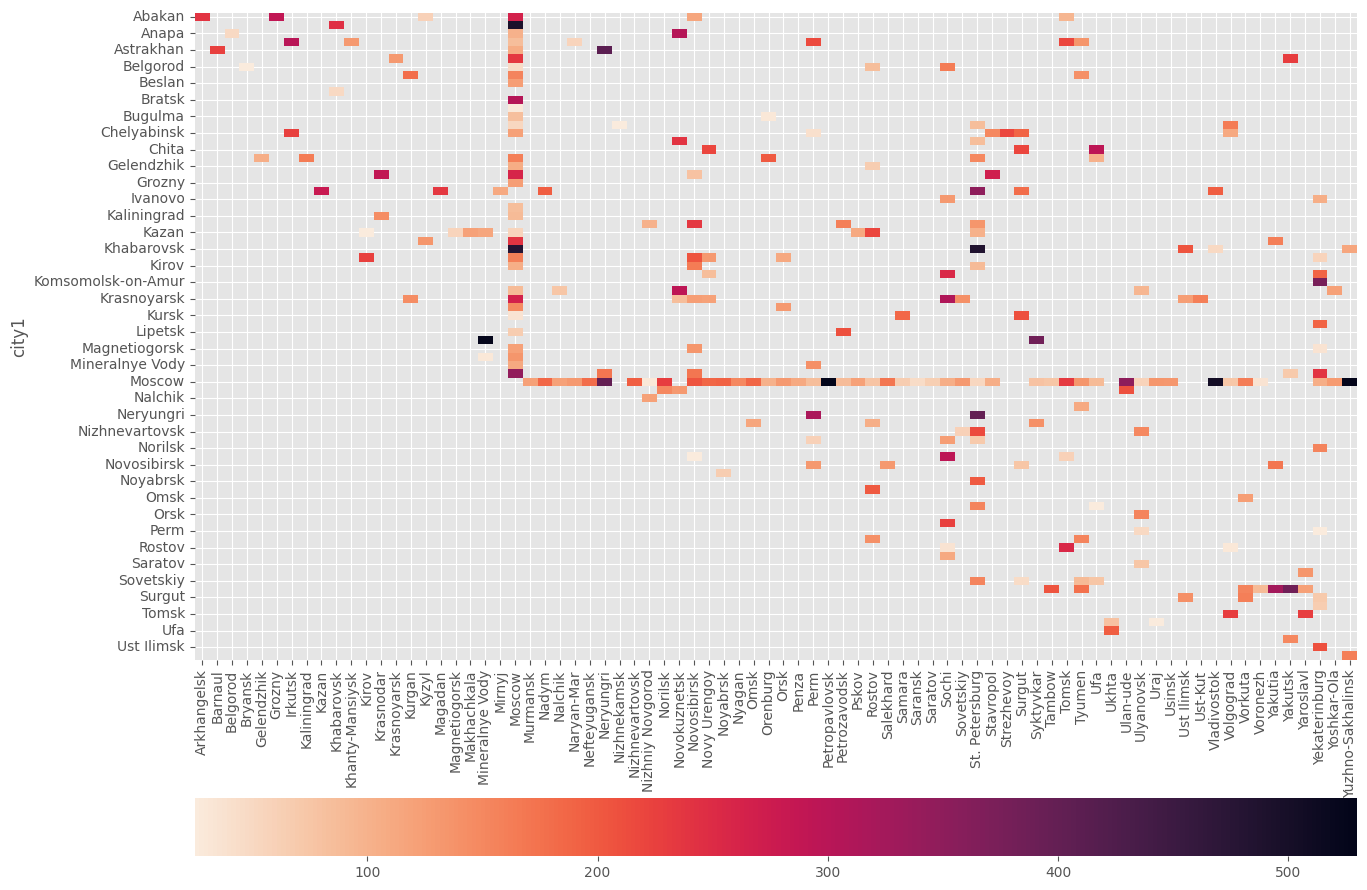

In [644]:
plt.figure(figsize=(15,12))
sns.heatmap(data= df4.set_index(["city1","city2"]).unstack(),
            xticklabels=df4.set_index(["city1","city2"]).unstack().columns.get_level_values(1),
            cmap=sns.color_palette("rocket_r",as_cmap=True),
            cbar_kws={"orientation": "horizontal"});
